In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score
from sklearn.metrics import log_loss
from sklearn import metrics

from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC

from IPython.display import Image
from six import StringIO
import graphviz
import pydot

In [2]:
ccdata = pd.read_csv('BankChurners.csv')

In [3]:
ccdata.drop("CLIENTNUM",axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',axis=1,inplace=True)
ccdata['Gender'].replace({'M':1,'F':0},inplace=True)
ccdata["Attrition_Flag"].replace({'Existing Customer':0,'Attrited Customer':1},inplace=True)
ccdata2 = pd.get_dummies(data=ccdata,columns=['Education_Level','Marital_Status',"Income_Category",'Card_Category'],drop_first=True)
ccdata2.drop(['Avg_Open_To_Buy','Customer_Age','Total_Trans_Ct','Months_on_book','Total_Amt_Chng_Q4_Q1'],axis=1,inplace=True)

In [4]:
X = ccdata2.drop("Attrition_Flag",axis=1)
y = ccdata2['Attrition_Flag']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

## hyperparameter optimization

In [11]:
randfor = RandomForestClassifier()

In [21]:
from sklearn.model_selection import GridSearchCV
#round 1
randforparam_grid = [
    {
        'criterion':['gini','entropy'],
        'n_estimators':[1,5,10,20,50,60,70,80,90,100],
        'max_depth':[5,10,15,20,25],
        'min_samples_leaf':[20,30,40,50,60]
    }
]

In [19]:
clf = GridSearchCV(randfor, param_grid = randforparam_grid, cv = 5, verbose=True, n_jobs = -1)

In [20]:
best_clf = clf.fit(X_train,y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [22]:
rawresults = pd.DataFrame(best_clf.cv_results_)
#rawresults

In [23]:
best_clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       n_estimators=10)

In [24]:
best_clf.best_score_

0.9115413978756844

## preliminary testing

In [6]:
from randforestmodule import randforest

randforestmodule.py is being imported into another module


In [7]:
rf1 = randforest(X_train,X_test,y_train,y_test)
rf1.KPI_summary()

accuracy score =  90.89 %
recall =  55.53 %
precision =  81.87 %
f2_score =  59.35 %
training accuracy =  92.56 %
testing accuracy =  90.89 %


                     Feature_names  Importances    cumsum
0                  Total_Trans_Amt     0.350572  0.350572
1              Total_Revolving_Bal     0.202119  0.552691
2              Total_Ct_Chng_Q4_Q1     0.139021  0.691712
3            Avg_Utilization_Ratio     0.086638  0.778349
4         Total_Relationship_Count     0.066795  0.845144
5                     Credit_Limit     0.044634  0.889778
6           Months_Inactive_12_mon     0.033305  0.923083
7            Contacts_Count_12_mon     0.025394  0.948477
8                           Gender     0.014235  0.962712
9                  Dependent_count     0.009622  0.972334
10          Marital_Status_Married     0.005013  0.977347
11           Marital_Status_Single     0.004029  0.981376
12  Income_Category_Less than $40K     0.003145  0.984520
13    Income_Category_$80K - $120K     0.001918  0.986438
14     Income_Category_$60K - $80K     0.001853  0.988291
15        Education_Level_Graduate     0.001670  0.989962
16      Educat

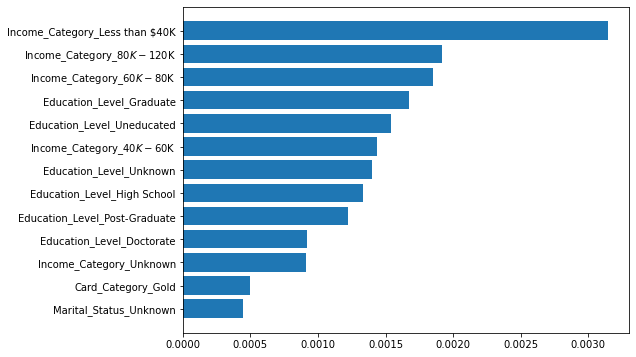

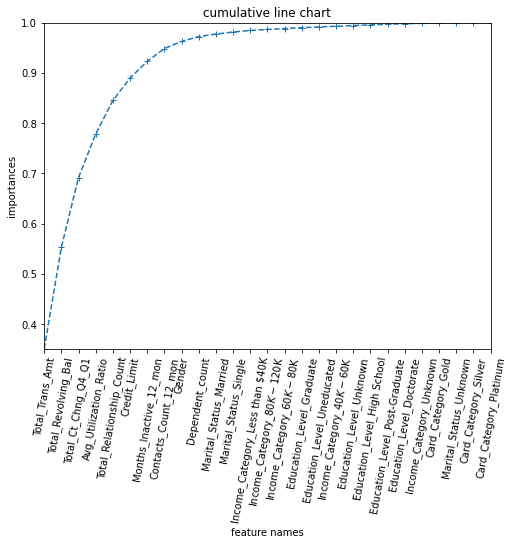

In [8]:
rf1.feature_importance()

In [9]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm, y_sm = smote.fit_resample(X_train,y_train)

print(y_sm.value_counts())
#generate train test split first then do resampling only on training set

#########

##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train3, y_train3 = pipeline.fit_resample(X_train,y_train)
print(y_train3.value_counts())

0    5949
1    5949
Name: Attrition_Flag, dtype: int64
0    3965
1    2379
Name: Attrition_Flag, dtype: int64


In [10]:
rf2 = randforest(X_sm,X_test,y_sm,y_test)
rf3 = randforest(X_train3,X_test,y_train3,y_test)

In [11]:
ls = [rf1,rf2,rf3]
[print(x.KPI_summary()) for x in ls]

accuracy score =  90.89 %
recall =  55.53 %
precision =  81.87 %
f2_score =  59.35 %
training accuracy =  92.56 %
testing accuracy =  90.89 %
None
accuracy score =  90.89 %
recall =  79.3 %
precision =  68.74 %
f2_score =  76.94 %
training accuracy =  93.8 %
testing accuracy =  90.89 %
None
accuracy score =  91.71 %
recall =  78.69 %
precision =  72.18 %
f2_score =  77.29 %
training accuracy =  91.8 %
testing accuracy =  91.71 %
None


[None, None, None]

## post-feature selection 

In [12]:
#feature selection
X_train2 = X_train.drop(['Marital_Status_Married','Marital_Status_Single','Income_Category_$80K - $120K','Income_Category_$80K - $120K','Income_Category_Less than $40K','Education_Level_Graduate','Education_Level_Post-Graduate','Education_Level_Unknown','Income_Category_Unknown','Income_Category_$60K - $80K','Education_Level_High School','Income_Category_$40K - $60K','Education_Level_Uneducated','Education_Level_Doctorate','Card_Category_Silver','Marital_Status_Unknown','Card_Category_Gold','Card_Category_Platinum'],axis=1)
X_test2 = X_test.drop(['Marital_Status_Married','Marital_Status_Single','Income_Category_$80K - $120K','Income_Category_$80K - $120K','Income_Category_Less than $40K','Education_Level_Graduate','Education_Level_Post-Graduate','Education_Level_Unknown','Income_Category_Unknown','Income_Category_$60K - $80K','Education_Level_High School','Income_Category_$40K - $60K','Education_Level_Uneducated','Education_Level_Doctorate','Card_Category_Silver','Marital_Status_Unknown','Card_Category_Gold','Card_Category_Platinum'],axis=1)

In [13]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm2, y_sm2 = smote.fit_resample(X_train2,y_train)

y_sm2.value_counts()
#generate train test split first then do resampling only on training set

##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train4, y_train4 = pipeline.fit_resample(X_train2,y_train)
y_train4.value_counts()

0    3965
1    2379
Name: Attrition_Flag, dtype: int64

In [14]:
rf4 = randforest(X_train2,X_test2,y_train,y_test)
rf5 = randforest(X_sm2,X_test2,y_sm2,y_test)
rf6 = randforest(X_train4,X_test2,y_train4,y_test)

In [15]:
ls1 = [rf4,rf5,rf6]
[print(x.f2_score) for x in ls]
[print(x.f2_score) for x in ls1]

0.5935173017958827
0.7693836978131212
0.7729468599033816
0.6596020761245673
0.8080808080808081
0.8264462809917356


[None, None, None]

## class weight rebalanced (pre & post-feature selection)

In [16]:
from randforestmodule import randforest_rebalanced

In [17]:
rf7 = randforest_rebalanced(X_train,X_test,y_train,y_test)
rf8 = randforest_rebalanced(X_sm,X_test,y_sm,y_test)
rf9 = randforest_rebalanced(X_train3,X_test,y_train3,y_test)
rf10 = randforest_rebalanced(X_train2,X_test2,y_train,y_test)
rf11 = randforest_rebalanced(X_sm2,X_test2,y_sm2,y_test)
rf12 = randforest_rebalanced(X_train4,X_test2,y_train4,y_test)

In [19]:
ls2 = [rf7,rf8,rf9,rf10,rf11,rf12]
[print(x.f2_score) for x in ls2]

0.8065141527723924
0.7803812549642574
0.8092155369383093
0.8269082498072474
0.8125
0.8314606741573033


[None, None, None, None, None, None]

In [20]:
#f2 score for rf1 to rf12
[print(x.f2_score) for x in ls]
[print(x.f2_score) for x in ls1]
[print(x.f2_score) for x in ls2]

0.5935173017958827
0.7693836978131212
0.7729468599033816
0.6596020761245673
0.8080808080808081
0.8264462809917356
0.8065141527723924
0.7803812549642574
0.8092155369383093
0.8269082498072474
0.8125
0.8314606741573033


[None, None, None, None, None, None]

In [21]:
rf12.KPI_summary()

accuracy score =  89.54 %
recall =  90.98 %
precision =  61.84 %
f2_score =  83.15 %
training accuracy =  92.53 %
testing accuracy =  89.54 %


              Feature_names  Importances    cumsum
0           Total_Trans_Amt     0.410775  0.410775
1       Total_Ct_Chng_Q4_Q1     0.157471  0.568246
2       Total_Revolving_Bal     0.118624  0.686870
3  Total_Relationship_Count     0.095508  0.782378
4              Credit_Limit     0.067177  0.849555
5     Avg_Utilization_Ratio     0.066776  0.916331
6                    Gender     0.026049  0.942381
7     Contacts_Count_12_mon     0.024767  0.967148
8    Months_Inactive_12_mon     0.021151  0.988300
9           Dependent_count     0.011700  1.000000


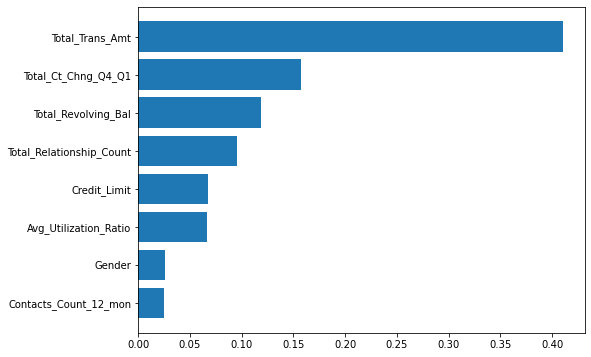

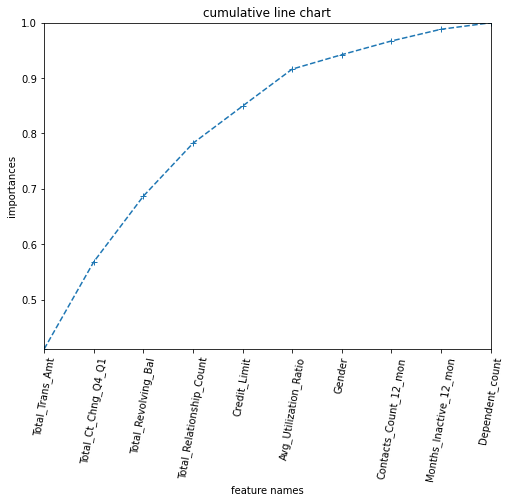

In [23]:
rf12.feature_importance()